In [108]:
import scdrs
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

In [109]:
disease_genes = scdrs.util.load_gs("/project2/gilad/jpopp/ebQTL/data/gene_sets/zhang.magma_10kb_1000.74_traits.gs")

In [110]:
scz_genes = disease_genes['PASS_Schizophrenia_Pardinas2018'][0]

Load normalized pseudobulk data

In [111]:
pb_loc = "/project2/gilad/jpopp/ebQTL/data/dynamic_qtl_calling/eb-neur_15binstrimmed/pseudobulk_tmm/nipals/expression.tsv"

In [112]:
neur_pb = pd.read_csv(pb_loc, sep="\t")

In [115]:
scz_pb = neur_pb.loc[neur_pb['gene'].isin(scz_genes)]

In [120]:
scz_pb

,gene,18486_bin10,18486_bin11,18486_bin12,18486_bin13,18486_bin14,18486_bin2,18486_bin3,18486_bin4,18486_bin5,...,19257_bin13,19257_bin14,19257_bin2,19257_bin3,19257_bin4,19257_bin5,19257_bin6,19257_bin7,19257_bin8,19257_bin9
30,ABCB9,1.035262,1.398000,1.643971,1.461428,1.516765,-0.388519,0.004566,-1.385970,0.000000,...,0.463526,2.034568,-1.829029,-1.626586,2.400036,1.043097,-0.773917,-1.328628,-1.362494,0.291732
447,ACD,-0.667342,-0.924567,-0.850110,-1.215846,-1.488527,1.043097,0.696144,0.091443,1.306870,...,-0.530698,-1.125272,0.077697,-0.843575,-0.063965,1.317671,1.398000,1.328628,1.245046,0.997006
450,ACHE,0.830612,0.627923,1.351033,1.448272,1.626586,-0.086859,0.096029,-0.673057,-0.917589,...,2.400036,1.936363,-0.678795,2.607994,-1.853908,-0.830612,-0.639083,-1.133914,-1.760493,0.917589
476,ACTL6B,0.306055,0.557167,0.499416,0.856681,0.655976,-0.535961,-0.573237,-0.448328,-0.611326,...,1.004540,1.328628,-1.461428,-1.151456,-1.448272,-1.435362,-0.856681,-0.719607,-0.202266,0.423225
486,ACTR5,1.245046,-0.022831,0.393447,0.910655,1.339746,0.123591,0.541240,-0.359141,-0.169747,...,0.368898,1.108237,0.192955,1.043097,1.879991,-1.516765,-0.364015,0.073118,-0.282216,-0.438254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12185,ZNRF3,-0.169747,-0.443286,-0.639083,-0.997006,-1.187647,0.562507,0.605832,0.982107,1.577180,...,-1.593219,-1.385970,1.531349,0.364015,-0.354275,0.478832,1.488527,0.211596,1.066994,0.267990
12198,ZSCAN2,-0.383600,-0.282216,0.639083,0.890111,0.869936,1.760493,0.876622,0.989529,0.584032,...,0.315639,0.974738,1.245046,0.910655,0.945777,-1.936363,-0.633493,-0.423225,-1.661868,-0.997006
12203,ZSCAN29,0.263261,0.022831,0.811424,1.004540,1.091517,-0.805095,-0.258537,0.114394,-1.398000,...,-0.151246,2.490664,-2.112911,-0.458449,-2.490664,-1.829029,-0.530698,0.325251,-0.349417,-0.952942
12211,ZSWIM6,0.458449,0.903765,0.483959,0.989529,1.739384,-1.577180,-1.265119,-0.713705,-0.458449,...,0.354275,1.178454,-1.306870,-0.896917,-1.151456,-0.541240,-0.160490,-0.123591,0.036535,-0.719607


In [121]:
scz_pb_long = scz_pb.melt(id_vars="gene", var_name="sample", value_name="exp")
scz_pb_long['donor'] = [s.split("_")[0] for s in scz_pb_long['sample']]
scz_pb_long['bin'] = [int(s.split("_bin")[1]) for s in scz_pb_long['sample']]

In [124]:
scz_pb_long

,gene,sample,exp,donor,bin
0,ABCB9,18486_bin10,1.035262,18486,10
1,ACD,18486_bin10,-0.667342,18486,10
2,ACHE,18486_bin10,0.830612,18486,10
3,ACTL6B,18486_bin10,0.306055,18486,10
4,ACTR5,18486_bin10,1.245046,18486,10
...,...,...,...,...,...
392530,ZNRF3,19257_bin9,0.267990,19257,9
392531,ZSCAN2,19257_bin9,-0.997006,19257,9
392532,ZSCAN29,19257_bin9,-0.952942,19257,9
392533,ZSWIM6,19257_bin9,-0.719607,19257,9


In [125]:
scz_pb_median = scz_pb_long.groupby(['gene', 'bin'])['exp'].median().reset_index().pivot(index="gene", columns="bin")

In [126]:
scz_pb_median

exp                                                              \
bin            2         3         4         5         6         7         8    
gene                                                                            
ABCB9   -0.673102 -0.713705 -0.997006 -0.684566 -0.670200 -0.476275 -0.174427   
ACD      0.938684  0.843575  0.611326  0.554740  0.382400  0.128227 -0.123602   
ACHE    -0.139711  0.096029 -0.578626 -0.893763 -0.956599 -0.798939 -0.325312   
ACTL6B  -0.525456 -0.737468 -1.206339 -0.979220 -0.945874 -0.320678 -0.006849   
ACTR5    0.121291  0.109800 -0.725535 -0.581499 -0.330257 -0.808260 -0.368968   
...           ...       ...       ...       ...       ...       ...       ...   
ZNRF3    0.549188  0.188305  0.000000  0.570240  1.099877  0.780331  0.260934   
ZSCAN2   1.771455  0.830612 -0.398385 -0.945874 -0.814605 -0.653171 -0.520278   
ZSCAN29 -0.821085 -0.551842 -1.043097 -0.900763 -0.554662 -0.212049  0.160496   
ZSWIM6  -1.553902 -1.116714 -1.035262 -0.499443 -0.137442  0.263264  0.061679   
ZZEF1   -0.758611 -0.767771 -1.050996 -1.201746 -0.650988 -0.230333 -0.052531   

                                                                     
bin            9         10        11        12        13        14  
gene                                                                 
ABCB9    0.190634  0.479140  0.625166  0.945777  0.850110  1.142641  
ACD      0.034261 -0.018265 -0.381154 -0.611326 -0.952942 -1.531349  
ACHE     0.079987  0.376249  0.496833  0.883346  0.863290  1.160362  
ACTL6B   0.213945  0.670331  0.725586  0.673057  0.917589  1.169360  
ACTR5   -0.386256  0.116829  0.215585  0.684555  0.622371  0.725535  
...           ...       ...       ...       ...       ...       ...  
ZNRF3    0.299030 -0.216326 -0.366544 -0.673057 -1.099838 -1.206339  
ZSCAN2  -0.209262 -0.025115  0.052542  0.334894  0.696144  0.743474  
ZSCAN29  0.153625  0.460987  0.378731  0.786296  0.830612  1.296220  
ZSWIM6   0.077710  0.249175  0.438453  0.373789  0.627923  1.410236  
ZZEF1    0.123596  0.466071  0.611336  0.725535  1.169360  1.680314  

[715 rows x 13 columns]

In [127]:
scz_pb_norm = pd.DataFrame(StandardScaler().fit_transform(scz_pb_median.T).T, index=scz_pb_median.index, columns=scz_pb_median.columns)

/home/jpopp/.conda/envs/pyro/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<AxesSubplot: >

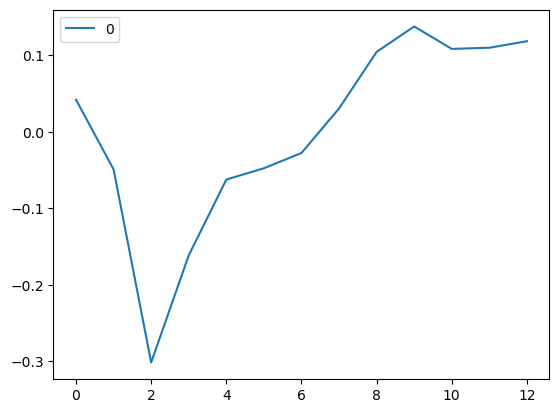

In [128]:
mean_effect = KMeans(n_clusters=1).fit(scz_pb_norm)
mean_trend = mean_effect.cluster_centers_
sns.lineplot(mean_trend.transpose())

In [129]:
np.random.seed(100)
scz_clustered = KMeans(n_clusters=3).fit(scz_pb_norm)

/home/jpopp/.conda/envs/pyro/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [130]:
scz_clustered.cluster_centers_

array([[ 1.67221153,  1.24664947,  0.80966993,  0.44130151,  0.09132094,
        -0.19522012, -0.28582926, -0.36810264, -0.45506507, -0.54006886,
        -0.56530981, -0.7570774 , -1.0944802 ],
       [-0.85409026, -0.85227289, -1.14227521, -0.96361268, -0.56338799,
        -0.23619386, -0.00714887,  0.23636808,  0.49712508,  0.71389408,
         0.78273925,  1.0066372 ,  1.38221809],
       [-0.88810869, -0.48806238, -0.17531615,  1.04811778,  1.22354881,
         0.92558424,  0.5192406 ,  0.30047014,  0.14127697, -0.1493938 ,
        -0.51217595, -0.78350297, -1.16167859]])

<AxesSubplot: >

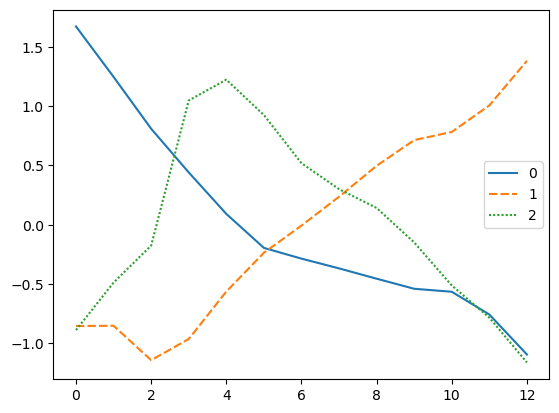

In [131]:
sns.lineplot(scz_clustered.cluster_centers_.transpose())

In [132]:
scz_cluster_map = {0: 'early', 1: 'late', 2: 'intermediate'}
scz_clusters = [scz_cluster_map[c] for c in scz_clustered.labels_]

In [133]:
scz_assignments = pd.DataFrame({'gene': scz_pb_median.index, 'cluster': scz_clusters}).set_index('gene').loc[[g for g in scz_genes if g in scz_pb_median.index]]

In [134]:
scz_assignments

,cluster
gene,
DPYD,late
RBFOX1,late
SPATS2L,early
PPP1R13B,early
SF3B1,early
...,...
NDUFAF2,late
ZNHIT3,late
ZZEF1,late


In [135]:
scz_assignments.to_csv("/project/gilad/jpopp/ebQTL/temp/SCZ.tsv", sep="\t")

In [136]:
scz_assignments.value_counts()

cluster     
late            353
early           255
intermediate    107
dtype: int64

In [138]:
scz_pb_norm.to_csv("/project/gilad/jpopp/ebQTL/temp/SCZ_genes_pseudobulk.tsv", sep="\t")

## Single-cell version

In [8]:
neur_adata = sc.read_h5ad("/project2/gilad/jpopp/ebQTL/data/trajectory_inference/eb-neur_lineage/eb-neur_lineage.15binstrimmed_pseudotime.adata")

In [23]:
scz_genes_detected = [g for g in scz_genes if g in neur_adata.var_names]

In [24]:
scz_adata = neur_adata[:, scz_genes_detected]

In [26]:
scz_exp = scz_adata.layers['log1pPF']

<136042x938 sparse matrix of type '<class 'numpy.float32'>'
	with 59387471 stored elements in Compressed Sparse Row format>

In [28]:
scz_pseudotime_sort = scz_adata[scz_adata.obs['pseudotime'].argsort()]

In [88]:
bin_size = 0.20  # Each bin contains 25% of the data
step_size = 0.10  # Rolling window slides by 2.5%

In [89]:
num_cells = scz_adata.shape[0]
cells_per_bin = int(num_cells * bin_size)
step_cells = int(num_cells * step_size)

In [90]:
smoothed_expression = []

for start in range(0, num_cells - cells_per_bin + 1, step_cells):
    end = start + cells_per_bin
    bin_mean_expression = np.mean(scz_pseudotime_sort.layers['log1pPF'][start:end, :], axis=0)
    smoothed_expression.append(bin_mean_expression)

smoothed_expression = np.vstack(smoothed_expression)

In [91]:
smoothed_df = pd.DataFrame(smoothed_expression).transpose()

In [92]:
smoothed_df.index = scz_adata.var_names

In [93]:
smoothed_df

,0,1,2,3,4,5,6,7,8
NRGN,0.003300,0.004331,0.005413,0.014539,0.031177,0.032813,0.021066,0.016623,0.012172
DPYD,0.005824,0.008196,0.014346,0.037164,0.061872,0.262123,0.909325,1.508211,1.524544
CACNA1I,0.003461,0.004699,0.005564,0.004492,0.002170,0.002784,0.005743,0.007873,0.008215
RBFOX1,0.630053,0.720762,0.861877,0.889414,0.817271,0.644678,0.621424,0.891293,1.104683
PPP1R16B,0.178229,0.199040,0.192987,0.111075,0.027653,0.015959,0.034851,0.053121,0.055428
...,...,...,...,...,...,...,...,...,...
ZNHIT3,0.874759,0.879770,0.871267,0.841751,0.800374,0.800711,0.853253,1.013409,1.346742
ZZEF1,0.160066,0.186942,0.197692,0.163969,0.146407,0.195837,0.285386,0.386600,0.485736
IL31,0.000000,0.000000,0.000112,0.000312,0.000248,0.000127,0.000163,0.000115,0.000069
MGRN1,0.250735,0.272445,0.279098,0.237630,0.215236,0.252945,0.306049,0.353215,0.393402


In [94]:
from sklearn.preprocessing import StandardScaler
smoothed_df_normalized = pd.DataFrame(StandardScaler().fit_transform(smoothed_df.T).T, index=smoothed_df.index, columns=smoothed_df.columns)

/home/jpopp/.conda/envs/pyro/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<AxesSubplot: >

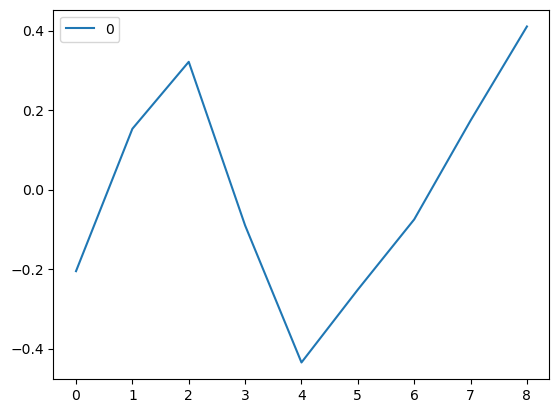

In [95]:
scz1 = KMeans(n_clusters=1).fit(smoothed_df_normalized)
sns.lineplot(scz1.cluster_centers_.transpose())

In [97]:
np.random.seed(100)
scz3 = SpectralClustering(n_clusters=3).fit(smoothed_df_normalized)
#sns.lineplot(scz3.cluster_centers_.transpose())

AttributeError: 'SpectralClustering' object has no attribute 'cluster_centers_'